## import numpy as np
import matplotlib.pyplot as plt

def from_x_to_matrix(x):
    n = int((-3 + np.sqrt(9+8*x.size))//2)
    k = x.size - n
    A = np.zeros((n, n))
    b = np.zeros(n)
    
    #Insert first k coefficients into matrix
    end = 0
    for j in range(n):
        start = end
        end = start + n-j
        A[j, j:] = x[start:end]
        A[j+1:,j] = A[j, j+1:]
    b = x[-n:] #Insert last n coefficients into vector
    return A, b

# Calculate h for single point z
def hi(x, zi):
    A, b = from_x_to_matrix(x)
    return zi.dot(A.dot(zi)) + b.dot(zi) - 1

# Calculate residual r for single point z
def r(x, zi, wi):
    return np.maximum(wi * hi(x, zi), 0)

#Calculate residual vector
def R(x, Z, W):
    m, n = Z.shape
    R = np.zeros(m)
    for i in range(R.size):
        R[i] = r(x, Z[i], W[i])
    return R

# Calculate objective function
def f(x, Z, W):
    m, n = Z.shape
    return np.sum(R(x, Z, W)**2)

# Calculate gradient oh h for single point z
def dhi(x, zi):
    n = zi.size
    k = n*(n+1)//2
    dh = np.zeros(k+n)
    end = 0
    for j in range(n):
        start = end
        end = start + n-j
        dh[start] = zi[j]**2
        dh[start+1:end] = 2 * zi[j] * zi[start+1:end]
    dh[-n:] = zi
    return dh

# Calculate gradient of residual r for  single point z
# h is the hi value for the given point
def dri(x, zi, wi, ri = None):
    n = zi.size
    dr = np.zeros(x.size)
    if ri == None:
        ri = r(x, zi, wi)
    return (ri > 0) * dhi(x, zi) * wi

# Calculate jacobian of residual vector R
def jacobi(x, Z, W, h = None):
    m, n = Z.shape
    J = np.zeros((m, x.size))
    for i in range(m):
        J[i] = dri(x, Z[i], W[i], h)
    return J

# Calculate gradient of objective function
def df(x, Z, W, h = None):
    return 2 * (jacobi(x, Z, W, h).T).dot(R(x, Z, W))

# Evaluate hi(x) for a matrix of columnvectors
def H(X, A, b):
    return ((X @ A) * X).sum(axis = 1) + (b * X).sum(axis = 1) - 1

In [2]:
################# RUN TEST ###################
# Finite difference test of gradient
def finite_difference_test(m = 10, n = 2):
    print("Finite differences verification of gradient")
    x, Z, W = generate_random(m, n)
    k = n*(n+1)//2
    p = np.random.randn(n+k)
    p = p/np.linalg.norm(p)
    f0 = f(x, Z, W)
    g = df(x, Z, W).dot(p)
    if g == 0:
        print("p: \n", p)
        print(df(x, Z, W))

    else:
        print("g = %e" %g)
        for ep in 10.0**np.arange(2, -9, -1):
            g_app = (f(x+ep*p, Z, W)-f0)/ep
            error = abs(g_app-g)/abs(g)
            print('ep = %e, error = %e, g_app = %e' % (ep,error, g_app))


# Generate a random set of points, weights, and unknowns
def generate_random(m, n):
    Z = np.random.randn(m*n).reshape(m, n)
    W = np.random.choice([-1.0, 1.0], m)
    x = np.array((1,0,1,0,0))
    return x, Z, W   


# Given A, b/c, evaluate function values for contourplot.
def evaluate_function(func, A, b, xlim = (-5, 5), ylim = (-5, 5)):
    x = np.linspace(*xlim, 101)
    y = np.linspace(*ylim, 101)
    xx, yy = np.meshgrid(x, y)
    X = np.stack((xx.flatten(), yy.flatten())).T
    return xx, yy, H(X, A, b).reshape(xx.shape)



def optimize(x, Z, W, method, func, ,backtrack = False, output = False):
    a, it = method(f, df, x, Z, W, backtrack)
    print("Iterations: ", it)
    A, b = from_x_to_matrix(a)
    xx, yy, C = evaluate_function(func, A, b)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.contour(xx, yy, C, levels = [0])
    ax1.plot(Z[W==1, 0], Z[W==1,1], 'o', color = 'b', label = "+")
    ax1.plot(Z[W==-1, 0], Z[W==-1,1], 'x', color = 'r', label = "-")
    ax1.legend()
    
    if output:
        print("W                Z                            W")
        Res = R(a, Z, W)
        for i in range(m):
            print(W[i], " ", Z[i], " "*10,  Res[i])

    return ax1


# Minimize and visualize objective function values for a random set of points
def optimize_random(m, n, method, func, output = False):
    x, Z, W = generate_random(m, n)
    a, it = method(f, df, x, Z, W)
    print("Iterations: ", it)
    A, b = from_x_to_matrix(a)
    xx, yy, C = evaluate_function(func, A, b)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.contour(xx, yy, C, levels = [0])
    ax1.plot(Z[W==1, 0], Z[W==1,1], 'o', color = 'b', label = "+")
    ax1.plot(Z[W==-1, 0], Z[W==-1,1], 'x', color = 'r', label = "-")
    ax1.legend()
    
    if output:
        print("W                Z                            W")
        Res = R(a, Z, W)
        for i in range(m):
            print(W[i], " ", Z[i], " "*10,  Res[i])

    return ax1

In [9]:
##### ALGORITHMS #############################################
def backtracking_line_search(f, gradf, p, x, Z, W):
    ρ = 0.5
    c = 0.05
    α = 0.5
    
    ϕ_k = f(x + α * p, Z, W)
    dF = gradf(x, Z, W)
    it = 0
    while (ϕ_k >= f(x, Z, W) + c * α * dF.dot(p) and it < 200):
        α = ρ * α
        ϕ_k = f(x + α * p, Z, W)
        it += 1
#     print(it)
    return α     
    
    
def line_search(f, grad,  p, x, z, w):
    
    #Line search algorithm satisfying strong Wolfe conditions. P. 60 in NW
    
    alpha_prev = 0
    alpha_max = 10000
    alpha_curr = 2
    
    #Picked some random numbers
    c1 = 1e-4
    c2 = 0.5
    
    i = 1
    while True:
        #print(f(x + alpha_curr*p))
        zero = np.array(np.zeros(len(x)))
        dPhi_0 = np.dot(grad(zero, z, w),p)
        dPhi_i = np.dot(grad(x + alpha_curr*p, z, w),p)
        
        #### FEIL I LINJEN UNDER?? Forskjell på ϕ og f
        if (f(x + alpha_curr*p, z, w) > f(x, z, w) + c1*alpha_curr*dPhi_0) or ((f(x + alpha_curr*p, z, w) >= f(x + alpha_prev*p, z, w) and i > 1)):
            return zoom(f, grad, p, x, c1, c2, alpha_curr, alpha_prev, z, w)
        
        if np.abs(dPhi_i) <= -c2*dPhi_0: 
            return alpha_curr
        if dPhi_i >= 0:
            return zoom(f, grad, p, x, c1, c2, alpha_prev, alpha_curr, z, w)
        
        alpha_prev = alpha_curr
        alpha_curr = (alpha_curr + alpha_max)/2
        
        i += 1
        
        #breaking point?
        if i == 1000:
            return alpha_curr
        
    
    
def interpolate(alpha2, alpha1, f, grad, p, x, z, w):
    
    #As described on p. 59 in NW. A cubic interpolation method to determine current step lenght within a interval    
    
    alpha_curr = alpha2
    alpha_prev = alpha1
    
    phi_curr = f(x + alpha_curr*p, z, w)
    phi_prev = f(x + alpha_prev*p, z, w)
    
    dPhi_curr = np.dot(grad(x + alpha_curr*p, z, w),p)
    dPhi_prev = np.dot(grad(x + alpha_prev*p, z, w),p)
    
    d1 = dPhi_prev + dPhi_curr - 3*(phi_prev - phi_curr)/(alpha_prev - alpha_curr)
    d2 = np.sign(alpha_curr - alpha_prev)*np.sqrt(d1**2 - dPhi_prev*dPhi_curr)
    
    
    return alpha_curr - (alpha_curr - alpha_prev)*(dPhi_curr + d2 - d1)/(dPhi_curr - dPhi_prev + 2*d2)

    
def zoom(f, grad, p, x, c1, c2, Alpha_high, Alpha_low, z, w):
    
    #Zoom algorithm as described on p. 61 in NW. Used for finding optimal step lenght
    alpha_low = Alpha_low
    alpha_high = Alpha_high
    
    i = 0
    tol = 10**-4
    alpha_curr = alpha_high
    alpha_prev = alpha_low
    while True:
        #Interpolate, choose alpha_j between hi & low
        #alpha_j = (alpha_high + alpha_low)/2
        
        if (np.abs(alpha_high - alpha_low) < tol):
            return alpha_high
        alpha_j = interpolate(alpha_high, alpha_low, f, grad, p, x, z, w)
        #print(alpha_j)
        zero = np.array(np.zeros(len(x)))
        phi_j = f(x + alpha_j*p, z, w)
        phi_low = f(x + alpha_low*p, z, w)
        
        dPhi_0 = np.dot(grad(x, z, w),p) # Bør være grad i x
        
        
        if (phi_j > f(x, z, w) + c1*alpha_j*dPhi_0) or (phi_j >= phi_low):
            alpha_high = alpha_j
        else:
            dPhi_i = np.dot(grad(x + alpha_j*p, z, w),p)
            if np.abs(dPhi_i) <= -c2*dPhi_0:
                return alpha_j
            if dPhi_i*(alpha_high - alpha_low) >= 0:
                alpha_high = alpha_low
            alpha_low = alpha_j
        
        #breaking point
        i += 1
        if i == 1000:
            #print(alpha_j)
            return alpha_j


# Optimization algorithms
def steepest_descent(f, grad, x0, Z, W, backtrack = True, tol = 1e-5, output = False):
    p = -df(x0, Z, W)
    x_k = x0
    it = 0
    
    while np.linalg.norm(p) > tol and it < 10000:
        
        if backtrack:
            α = backtracking_line_search(f, grad, p, x_k, Z, W)
        else:
            α = line_search(f, grad, p, x_k, Z, W)
            
        x_k = x_k + α * p
        p = -df(x_k, Z, W)
        it += 1
        
        if it % 500 and output == 0:
            print("\niter:", it)
            print("α =", α)
            print("f(x) =", f(x_k, Z, W))
            print("\n")
    return x_k, it


# Optimization algorithm
def bfgs_method(f, grad, x0, Z, W, backtrack = True, tol = 1e-5, output = False):
    m, n = Z.shape
    k = n*(n+1)//2

    I = np.identity(n + k)
    H = I
    
    x_k = x0
    dF = grad(x_k, Z, W)
    
    it = 0
    while np.linalg.norm(dF) > tol and it < 10000:
        dF = grad(x_k, Z, W)
        
        p_k = - H.dot(dF)
        p_k = p_k/np.linalg.norm(p_k)
        
        if backtrack:
            α_k = backtracking_line_search(f, grad, p_k, x_k, Z, W)
        else:
            α_k = line_search(f, grad, p_k, x_k, Z, W)
        
        x_next = x_k + α_k * p_k
        dF_next = grad(x_next, Z, W)
        
        s_k = x_next - x_k
        y_k = dF_next - dF
        
        # Check if "reboot" is needed
        if s_k.dot(y_k) == 0:
            H = I
            continue
            
        # computing rho (6.14 in NW)
        ρ_k = 1/(np.dot(s_k,y_k))
        
        
        H = (I - ρ_k * s_k * y_k.T) @ H @ (I - ρ_k * y_k * s_k.T) + ρ_k * s_k * s_k.T
        
        it += 1
        
        x_k = x_next
        dF = dF_next
        
        # Print progress
        if it % 200 and output == 0:
            print("\niter:", it)
            print("α =", α_k)
            print("f(x) =", f(x_k, Z, W))
            print("\n")
        
        #print("df: ", np.linalg.norm(df(x, Z, W)))
    return x_k, k, f(x_k, Z, W)

In [10]:
m, n = (15, 2)
x, Z, W = generate_random(m, n)

Iter:  3
f(x):  0.0158873492751


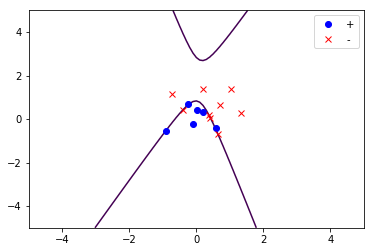

In [11]:
a, it, SSE= bfgs_method(f, df, x, Z, W, backtrack = True)
print("Iter: ", it)
print("f(x): ", SSE)

A, b = from_x_to_matrix(a)
xx, yy, C = evaluate_function(H, A, b)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.contour(xx, yy, C, levels = [0])
ax1.plot(Z[W==1, 0], Z[W==1,1], 'o', color = 'b', label = "+")
ax1.plot(Z[W==-1, 0], Z[W==-1,1], 'x', color = 'r', label = "-")
ax1.legend()
plt.show()


iter: 200
α = 3.86229391474e-05
f(x) = 0.0158873570157


Iter:  3
f(x):  0.015887349396


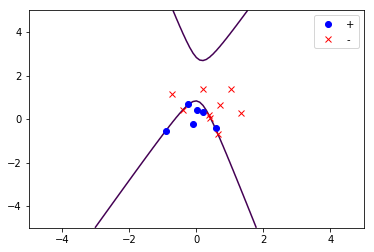

In [12]:
a, it, SSE = bfgs_method(f, df, x, Z, W, backtrack = False)
print("Iter: ", it)
print("f(x): ", SSE)

A, b = from_x_to_matrix(a)
xx, yy, C = evaluate_function(H, A, b)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.contour(xx, yy, C, levels = [0])
ax1.plot(Z[W==1, 0], Z[W==1,1], 'o', color = 'b', label = "+")
ax1.plot(Z[W==-1, 0], Z[W==-1,1], 'x', color = 'r', label = "-")
ax1.legend()
plt.show()

In [8]:
# if __name__ == "__main__":
if False:
    n = 2
    for m in [3, 5, 7, 10, 12, 15]:
        fig = optimize_random(m, n, steepest_descent, H, output = True)
        fig.axes.set_title("Model 2: " + str(m)+" points, Steepest Descent")
        plt.savefig("./figures/model2_steep_descent"+ str(m) +".png")
        
        fig = optimize_random(m, n, bfgs_method, H, output = True)
        fig.axes.set_title("Model 2: " + str(m)+" points, BFGS Method")
        plt.savefig("./figures/model2_bfgs_method" + str(m) +".png")